# Label Analysis
Now that Ge has produced some example labels we can start looking for meaningful relationships in the data

In [17]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import scipy.stats
import json
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter

import missingno as msno
import os
import glob
import ast
from copy import deepcopy
import statsmodels.api as sm

from matplotlib import rcParams
rcParams['figure.figsize'] = 20,10

/homes/gws/mikeam/anaconda3/envs/analysis/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


# Cleaning and Loading Data

In [1]:
# # LABELS_RAW = "/projects/bdata/jupyter/results/stage2code.json"
# LABELS_RAW = "/projects/bdata/jupyter/results/train/results_graphs_layer_4_1_12.model.ep2_0116_2020.txt"
LABELS_RAW = "/projects/bdata/jupyter/results/annotation/graphs_11.txt"
ACADEMIC_LABELS_RAW = "/projects/bdata/jupyter/results/academic/results_graphs_layer_4_1_12.model.ep2_0122_2020.txt"
# with open(LABELS_RAW) as json_data:
#     data = json.load(json_data)

In [2]:
READABLE_LABELS = ["STAGE_PAD","WRANGLE","EXPLORE","MODEL","EVALUATE","IMPORT"]
ORDERED_LABELS = ["IMPORT","WRANGLE","EXPLORE","MODEL","EVALUATE","STAGE_PAD"]
READABLE_LABEL_TO_INT = dict(zip(READABLE_LABELS,range(len(READABLE_LABELS))))

def path_to_nb_id(path):
    filename = path.split("/")[-1]
    no_ext = filename.split(".")[0]
    no_prefix = no_ext.split("_")[-1]
    return int(no_prefix)

def split_lines(string):
    try:
        return string.splitlines()
    except AttributeError:
        return None

In [5]:
results = pd.read_json(LABELS_RAW,lines=True)
results["dataset"] = "filtered"

In [6]:
results["label"] = results["pred"]
results["readable_label"] = results["label"].map(lambda x: READABLE_LABELS[x])
results["converted_py_lineno"] = results["target_lineno"]
results["n_lines"] = results["context"].map(lambda x: len(split_lines(x)))
results["nb_id"] = results["file"].map(path_to_nb_id)
results["code_line_no"] = (results.sort_values("target_lineno").groupby("nb_id")["n_lines"].cumsum().shift() + 1 ).fillna(0)

In [7]:
# results = []
# for label, cells in data.iteritems():
#     for cell in cells:
#         result = {"label":int(label),
#                   "readable_label" : READABLE_LABELS[int(label)],
#                   "converted_py_lineno":int(cell["target_lineno"]),
#                   "n_lines":len(cell["context"].splitlines()),
#                   "path" : cell["file"],
#                   "nb_id":path_to_nb_id(cell["file"])}
#         results.append(result)
# results = pd.DataFrame(results).sort_values(["nb_id","converted_py_lineno"])
# results["code_line_no"] = (results.groupby("nb_id")["n_lines"].cumsum().shift() + 1 ).fillna(0)

In [8]:
results.head()

,target_lineno,file,context,target_func,nodes,funcs,stage,id,neighbor_cells,header,...,idx_map,pred,stage_vec,dataset,label,readable_label,converted_py_lineno,n_lines,nb_id,code_line_no
0,183,/projects/bdata/jupyter/_7_1/nb_1053523.py,\nx0 = [x[0] for x in train]\n\nx1 = [x[1] for...,none_func,"[{'type': 'Module', 'children': [1, 11, 21, 36...","[matplotlib.cm.jet, max, matplotlib.pyplot.fig...",2,74,[73],PCA to 150 dimensional space,...,"{'0': [0], '1': [1], '2': [2, 3], '3': [4], '4...",2,"[-2.149143695831299, -2.429313898086548, 30.93...",filtered,2,EXPLORE,183,18,1053523,69.0
1,61,/projects/bdata/jupyter/_7_1/nb_1170705.py,\nnum_topics = 20\n\nnum_top_words = 20\n\nclf...,none_func,"[{'type': 'Module', 'children': [1, 4, 7, 17, ...","[sklearn.decomposition.NMF, sklearn.decomposit...",3,424,[423],[EMPTY],...,"{'0': [0], '1': [1], '2': [2, 3], '3': [4], '4...",3,"[-2.989803314208984, -1.214049339294433, 4.552...",filtered,3,MODEL,61,18,1170705,65.0
2,9,nb_1221634,\nfor i in stems:\n if (len(stems[i][0]) ==...,none_func,"[{'type': 'Module', 'children': [1, 49]}, {'ty...","[len, len]",1,156,[-1],,...,"{'0': [0], '1': [1], '2': [2], '3': [3], '4': ...",1,"[-6.59837007522583, 23.175315856933594, 0.5943...",filtered,1,WRANGLE,9,8,1221634,84.0
3,10,/projects/bdata/jupyter/_7_1/nb_1185862.py,\nfile = open('C:/Users/Inance/Documents/Thesi...,none_func,"[{'type': 'Module', 'children': [1, 6, 9, 28, ...","[open, append, float, line.split, numpy.array,...",1,18,[17],Import Libraries,...,"{'0': [0], '1': [1], '2': [2], '3': [3], '4': ...",2,"[-3.463528394699096, 10.72555923461914, 26.439...",filtered,2,EXPLORE,10,15,1185862,211.0
4,14,/projects/bdata/jupyter/_7_1/nb_1215903.py,\nrng = np.random.RandomState(0)\n\nn_samples_...,none_func,"[{'type': 'Module', 'children': [1, 10, 13, 16...","[numpy.random.RandomState, numpy.random.Random...",1,299,[298],[EMPTY],...,"{'0': [0], '1': [1], '2': [2], '3': [3], '4': ...",1,"[-6.39727783203125, 24.1392822265625, 1.701260...",filtered,1,WRANGLE,14,12,1215903,12.0


Number of Labeled Cells:

In [9]:
len(results)

1745

Number of Labled Notebooks:

In [10]:
results["file"].nunique()

97

Fraction of cells that include each label:

In [11]:
results["readable_label"].value_counts(normalize = True)

EXPLORE     0.556447
WRANGLE     0.269914
MODEL       0.093983
IMPORT      0.058453
EVALUATE    0.021203
Name: readable_label, dtype: float64

# Markov Process
Let's find the transition matrix between sequential states

In [12]:
sequences = results.sort_values(["nb_id","code_line_no"]).groupby(["nb_id"])["label"].apply(list)
sequences.head()

nb_id
1000752    [5, 1, 2, 2, 5, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, ...
1002722                    [1, 2, 5, 2, 1, 2, 1, 2, 2, 2, 1]
1004385                                [1, 2, 5, 1, 2, 2, 2]
1005070    [2, 2, 1, 2, 4, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, ...
1005207    [1, 2, 1, 2, 3, 3, 2, 3, 3, 2, 1, 2, 2, 1, 1, ...
Name: label, dtype: object

In [15]:
def get_transition_matrix(X,n_states = len(READABLE_LABELS),
                          normalize = True):
    M = np.zeros((n_states,n_states))
    for row in X:
        for xi,xi1 in zip(row,row[1:]):
            M[xi,xi1] += 1
    if normalize:
        M = M / M.sum(axis = 1)[:,None]
    return M

transitions = pd.DataFrame(get_transition_matrix(sequences.values),
                           columns=READABLE_LABELS,
                           index = READABLE_LABELS)
transitions.index = pd.CategoricalIndex(transitions.index, categories= ORDERED_LABELS)
transitions.sort_index(level=0, inplace=True)

transitions.columns = pd.CategoricalIndex(transitions.columns, categories= ORDERED_LABELS)
transitions.sort_index(axis=1,inplace = True)

/homes/gws/mikeam/anaconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


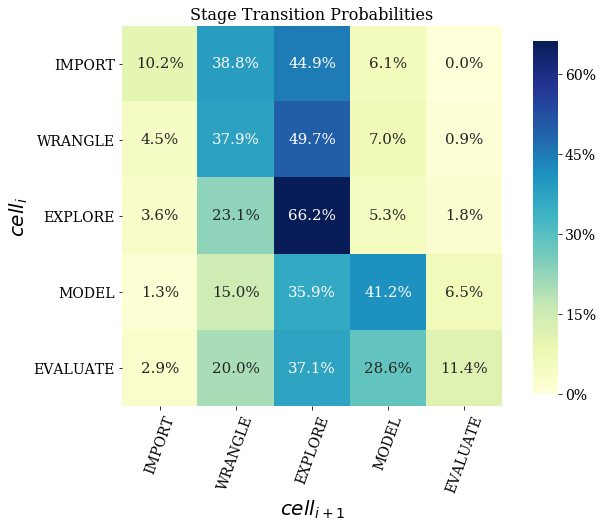

In [40]:
with plt.style.context('publications.mplstyle'): 
    
    fig, ax = plt.subplots(figsize=(7,7))  
    cbar_ax = fig.add_axes([.95, 0.15, .05, .7])
    g = sns.heatmap(transitions.iloc[:-1,:-1],annot = True, fmt = ".1%", square = True,cmap="YlGnBu" ,
                    ax = ax, cbar_ax=cbar_ax, cbar_kws={'format': '%.0f%%'})
#     plt.figure(figsize=(9,8))


    cbar_ax.yaxis.set_major_formatter(PercentFormatter(1, 0))
    
    
    ax.set_title("Stage Transition Probabilities")
    ax.set_ylabel("$cell_i$", size = 20)
    ax.set_xlabel("$cell_{i+1}$", size = 20)
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=70 )

    
    for tick in plt.gca().yaxis.get_major_ticks():
        tick.label1.set_verticalalignment('center')
#     plt.tight_layout()
    plt.savefig("figs/transitions.pdf",bbox_inches="tight",transparent = True)
    
    

## Takeaways:
* Likely to go from `IMPORT` to `WRANGLE` $\,\to\,$ Matches our model of the process
* Likely to stay in the same state $\,\to\,$ Does this make sense?
* Could probably do some "paper two" work on modeling these sequences
* Could comparse to results using cell execution order

# Location in the Document?

Text(3.799999999999997, 0.5, 'Average Line Number')

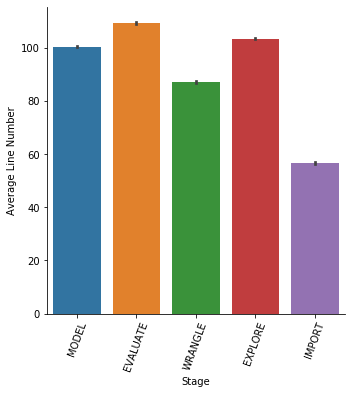

In [14]:
g = sns.catplot(data = results, y = "code_line_no", x = "readable_label",kind = "bar",
               col_order = ORDERED_LABELS)
plt.xticks(rotation=70)
plt.xlabel("Stage")
plt.ylabel("Average Line Number")

# Normalized Location in Document

Bad val "'ps'," on line #1
	"backend: 'ps',
"
	in file "publications.mplstyle"
	Key backend: Unrecognized backend string "'ps',": valid strings are ['GTK3Agg', 'GTK3Cairo', 'MacOSX', 'nbAgg', 'Qt4Agg', 'Qt4Cairo', 'Qt5Agg', 'Qt5Cairo', 'TkAgg', 'TkCairo', 'WebAgg', 'WX', 'WXAgg', 'WXCairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template']
Bad val '8,' on line #3
	"axes.labelsize: 8, # fontsize for x and y labels (was 10)
"
	in file "publications.mplstyle"
	Key axes.labelsize: 8, is not a valid font size. Valid font sizes are xx-small, x-small, small, medium, large, x-large, xx-large, smaller, larger.
Bad val '8,' on line #4
	"axes.titlesize: 8,
"
	in file "publications.mplstyle"
	Key axes.titlesize: 8, is not a valid font size. Valid font sizes are xx-small, x-small, small, medium, large, x-large, xx-large, smaller, larger.

Bad key "text.size'" on line 5 in
publications.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/b

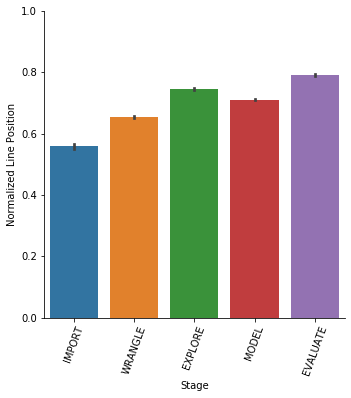

In [90]:
nb_lengths = (results
              .merge(results.groupby("nb_id")["n_lines"].sum().rename("total_nb_length"),
                     how = "left",
                     on = "nb_id"))
nb_lengths["normalized_position"] = nb_lengths["code_line_no"] / nb_lengths["total_nb_length"]
with plt.style.context('publications.mplstyle'):    
    g = sns.catplot(data = nb_lengths, y = "normalized_position", x = "readable_label",
                    kind = "bar", order = ORDERED_LABELS[:-1])
    plt.ylim(0,1)
    plt.xticks(rotation=70)
    plt.xlabel("Stage")
    plt.ylabel("Normalized Line Position")
    plt.savefig("figs/norm_doc_location.pdf",bbox_inches="tight",transparent = True)

In [16]:
len(results)

2003657

## Takeaways:
* On average, the order is `WRANGLE`/`IMPORT` $\,\to\,$ `EXPLORE`/`MODEL` $\,\to\,$ `EVALUATE`

# Relating Notebooks to Repos

In [17]:
notebook_info = pd.read_csv("/projects/bdata/jupyter/notebook_info/notebooks.csv")
notebook_info.head()

,nb_id,html_url,max_filesize,min_filesize,name,path,query_page,repo_id
0,0,https://github.com/dalequark/emotivExperiment/...,10,0,EmotivDataAnalysis.ipynb,ipynb/EmotivDataAnalysis.ipynb,1,26093748
1,1,https://github.com/kevcisme/madelon_redux/blob...,10,0,Part_IV_Project_3-checkpoint_BASE_63907.ipynb,ipynb/.ipynb_checkpoints/Part_IV_Project_3-che...,1,95729593
2,2,https://github.com/HaraldoFilho/DLND-Projects/...,10,0,_.ipynb,_.ipynb,1,88182909
3,3,https://github.com/mhjensen/CPMLS/blob/4a5b37e...,10,0,csexmas2015.ipynb,doc/pub/CSETalks/csexmas2015/ipynb/csexmas2015...,1,35169104
4,4,https://github.com/freqn/atom_configuration/bl...,10,0,jupyter.ipynb,packages/file-icons/examples/jupyter.ipynb,1,57460377


In [18]:
#Discard columns with mixed datatypes that we don't use anyway:
REPO_INFO_DISCARD_COLUMNS = {"mirror_url",'allow_merge_commit', 'allow_rebase_merge', 'allow_squash_merge'}
repo_info = pd.read_csv("/projects/bdata/jupyter/cleaned_repo_metadata.csv",
                        usecols = lambda x: x not in REPO_INFO_DISCARD_COLUMNS)
repo_info.head()

,created_at,default_branch,description,fork,forks,forks_count,full_name,git_url,has_downloads,has_issues,...,permissions,private,pushed_at,size,ssh_url,stargazers_count,subscribers_count,updated_at,watchers,watchers_count
0,2013-05-11T20:49:36Z,master,Educational Python,False,0.0,0.0,pratiks/PyEducation,git://github.com/pratiks/PyEducation.git,True,True,...,"{'admin': False, 'push': False, 'pull': True}",False,2013-05-13T16:18:48Z,168.0,git@github.com:pratiks/PyEducation.git,0.0,0.0,2013-10-11T07:19:53Z,0.0,0.0
1,2013-05-11T21:46:33Z,ProjDev,NaN,False,0.0,0.0,danstrawser/Nlp2Commands,git://github.com/danstrawser/Nlp2Commands.git,True,True,...,"{'admin': False, 'push': False, 'pull': True}",False,2015-12-15T00:29:05Z,46146.0,git@github.com:danstrawser/Nlp2Commands.git,0.0,1.0,2015-12-02T06:04:02Z,0.0,0.0
2,2013-05-12T00:24:17Z,master,Simple code for time domain simulations of the...,False,1.0,1.0,IanHawke/MultiFluid1d,git://github.com/IanHawke/MultiFluid1d.git,True,True,...,"{'admin': False, 'push': False, 'pull': True}",False,2015-07-16T08:58:15Z,7741.0,git@github.com:IanHawke/MultiFluid1d.git,0.0,1.0,2015-07-16T08:58:15Z,0.0,0.0
3,2013-05-12T06:19:15Z,master,The official sources for the RDKit library,False,154.0,154.0,rdkit/rdkit,git://github.com/rdkit/rdkit.git,True,True,...,"{'admin': False, 'push': False, 'pull': True}",False,2017-07-22T11:54:08Z,103731.0,git@github.com:rdkit/rdkit.git,248.0,61.0,2017-07-20T10:53:57Z,248.0,248.0
4,2013-05-12T07:37:28Z,master,NaN,False,4.0,4.0,Hanjun-Dai/lecast,git://github.com/Hanjun-Dai/lecast.git,True,True,...,"{'admin': False, 'push': False, 'pull': True}",False,2013-05-12T07:43:33Z,3594.0,git@github.com:Hanjun-Dai/lecast.git,1.0,1.0,2014-05-30T10:56:49Z,1.0,1.0


In [19]:
results_with_repo = nb_lengths.merge(notebook_info, on = "nb_id", how = "left").sort_values("repo_id")\
                              .merge(repo_info, left_on = "repo_id", right_on = "id")\

## How many notebooks are in the average repo?

In [20]:
results_with_repo.drop_duplicates(subset=["nb_id"]).groupby("repo_id").size().describe()

count    42577.000000
mean         2.773892
std          8.497878
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       1213.000000
dtype: float64

# Analysis Stages and Academic Papers

In [21]:
gorc_github_refs = pd.read_csv("gorc_github_refs.csv")
gorc_github_refs = gorc_github_refs.rename(columns = {"repo_name":"full_name"})
gorc_github_refs.head()

/homes/gws/mikeam/anaconda3/envs/analysis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,abstract,acl_id,arxiv_id,authors,doi,github_refs,journal,paper_id,pmc_id,pubmed_id,title,venue,year,full_name
0,PREMISE OF THE STUDY California's vascular flo...,NaN,NaN,"[{'first': 'Bruce', 'middle': ['G'], 'last': '...",10.3732/ajb.1600326,['github.com/OpenRefine'],American journal of botany,43052386,NaN,28341628.0,Species richness and endemism in the native fl...,American journal of botany,2017.0,NaN
1,Background: Reduced-representation sequencing ...,NaN,NaN,"[{'first': 'Jinpeng', 'middle': [], 'last': 'W...",10.1016/j.ejbt.2016.02.003,['github.com/JINPENG-WANG'],Electronic Journal of Biotechnology,56063937,NaN,NaN,RestrictionDigest: A powerful Perl module for ...,Electronic Journal of Biotechnology,2016.0,NaN
2,This thesis presents different methods of anal...,NaN,NaN,"[{'first': 'Nejc', 'middle': [], 'last': 'Šilc...",NaN,['github.com/nejcsilc/lpa'],NaN,63301592,NaN,NaN,Communication Protocols Analysis and Testing Tool,NaN,2016.0,nejcsilc/lpa
3,"We present BubbleProfiler, a C++ software pack...",NaN,1901.03714,"[{'first': 'Peter', 'middle': [], 'last': 'Ath...",10.1016/j.cpc.2019.05.017,"['github.com/bubbleprofiler/bubbleprofiler', '...",Computer Physics Communications,68153807,NaN,NaN,BubbleProfiler: finding the field profile and ...,Comput.Phys.Commun. 244 (2019) 448-468,2019.0,bubbleprofiler/bubbleprofiler
4,"We present BubbleProfiler, a C++ software pack...",NaN,1901.03714,"[{'first': 'Peter', 'middle': [], 'last': 'Ath...",10.1016/j.cpc.2019.05.017,"['github.com/bubbleprofiler/bubbleprofiler', '...",Computer Physics Communications,68153807,NaN,NaN,BubbleProfiler: finding the field profile and ...,Comput.Phys.Commun. 244 (2019) 448-468,2019.0,bubbleprofiler/bubbleprofiler


In [22]:
len(gorc_github_refs["year"].dropna())

78041

In [23]:
gorc_github_refs.head()

,abstract,acl_id,arxiv_id,authors,doi,github_refs,journal,paper_id,pmc_id,pubmed_id,title,venue,year,full_name
0,PREMISE OF THE STUDY California's vascular flo...,NaN,NaN,"[{'first': 'Bruce', 'middle': ['G'], 'last': '...",10.3732/ajb.1600326,['github.com/OpenRefine'],American journal of botany,43052386,NaN,28341628.0,Species richness and endemism in the native fl...,American journal of botany,2017.0,NaN
1,Background: Reduced-representation sequencing ...,NaN,NaN,"[{'first': 'Jinpeng', 'middle': [], 'last': 'W...",10.1016/j.ejbt.2016.02.003,['github.com/JINPENG-WANG'],Electronic Journal of Biotechnology,56063937,NaN,NaN,RestrictionDigest: A powerful Perl module for ...,Electronic Journal of Biotechnology,2016.0,NaN
2,This thesis presents different methods of anal...,NaN,NaN,"[{'first': 'Nejc', 'middle': [], 'last': 'Šilc...",NaN,['github.com/nejcsilc/lpa'],NaN,63301592,NaN,NaN,Communication Protocols Analysis and Testing Tool,NaN,2016.0,nejcsilc/lpa
3,"We present BubbleProfiler, a C++ software pack...",NaN,1901.03714,"[{'first': 'Peter', 'middle': [], 'last': 'Ath...",10.1016/j.cpc.2019.05.017,"['github.com/bubbleprofiler/bubbleprofiler', '...",Computer Physics Communications,68153807,NaN,NaN,BubbleProfiler: finding the field profile and ...,Comput.Phys.Commun. 244 (2019) 448-468,2019.0,bubbleprofiler/bubbleprofiler
4,"We present BubbleProfiler, a C++ software pack...",NaN,1901.03714,"[{'first': 'Peter', 'middle': [], 'last': 'Ath...",10.1016/j.cpc.2019.05.017,"['github.com/bubbleprofiler/bubbleprofiler', '...",Computer Physics Communications,68153807,NaN,NaN,BubbleProfiler: finding the field profile and ...,Comput.Phys.Commun. 244 (2019) 448-468,2019.0,bubbleprofiler/bubbleprofiler


In [24]:
results_with_gorc = results_with_repo.merge(gorc_github_refs,how="left",on = "full_name")
results_with_gorc["is_academic"] = ~results_with_gorc["title"].isnull()

In [139]:
results_with_repo.merge(gorc_github_refs,how="inner",on = "full_name")["nb_id"].nunique()

584

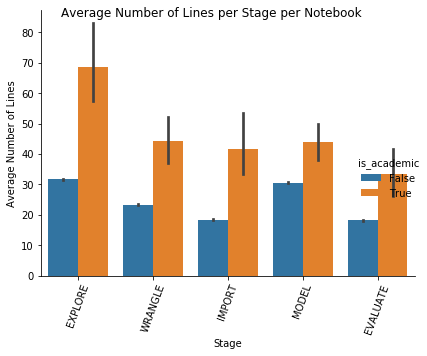

In [25]:
g = sns.catplot(data = (results_with_gorc.groupby(["is_academic","nb_id","readable_label"])
                        ["n_lines"].sum().reset_index())
                , hue = "is_academic", y = "n_lines", x = "readable_label",kind = "bar")
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 70)
    ax.set_xlabel("Stage")
    ax.set_ylabel("Average Number of Lines")

plt.suptitle("Average Number of Lines per Stage per Notebook")
plt.tight_layout()

In [26]:
results_with_gorc.drop_duplicates("nb_id").groupby("is_academic").size()

is_academic
False    117520
True        584
dtype: int64

Text(0.5, 0.98, 'Average Number of Lines per Notebook')

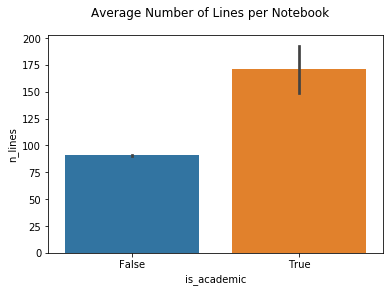

In [27]:
academic_nb_lengths = results_with_gorc.groupby(["nb_id","is_academic"])["n_lines"].sum().reset_index()
sns.barplot(x = academic_nb_lengths["is_academic"],
            y = academic_nb_lengths["n_lines"])

#     ax.set_xticklabels(ax.get_xticklabels(),rotation = 70)
#     ax.set_xlabel("Is Academic")
#     ax.set_ylabel("Total Number of Lines")

plt.suptitle("Average Number of Lines per Notebook")
# plt.tight_layout()

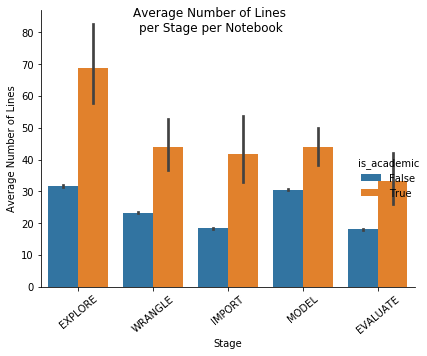

In [96]:
g = sns.catplot(data = (results_with_gorc.groupby(["is_academic","nb_id","readable_label"])
                        ["n_lines"].sum().reset_index())
                , hue = "is_academic", y = "n_lines", x = "readable_label",kind = "bar")
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 40)
    ax.set_xlabel("Stage")
    ax.set_ylabel("Average Number of Lines")

plt.suptitle("Average Number of Lines \nper Stage per Notebook")
plt.tight_layout()

In [29]:
results_with_gorc.groupby(["is_academic"])["nb_id"].nunique()

is_academic
False    117520
True        584
Name: nb_id, dtype: int64

# Number of stars:

In [30]:
results_with_gorc["stargazers_count"].describe()

count    2.008708e+06
mean     1.888661e+01
std      5.403466e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      6.453800e+04
Name: stargazers_count, dtype: float64

In [31]:
results_with_gorc[results_with_gorc["is_academic"]]["stargazers_count"].describe()

count    17539.000000
mean      1526.620446
std       5442.529066
min          0.000000
25%          1.000000
50%         14.000000
75%       1531.000000
max      64538.000000
Name: stargazers_count, dtype: float64

Text(0.5, 1, 'Median Number of Stars')

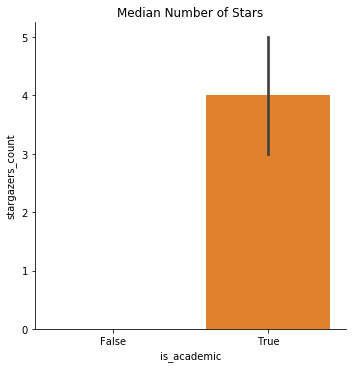

In [32]:
g = sns.catplot(data = (results_with_gorc.drop_duplicates("nb_id")),
                 x = "is_academic", y = "stargazers_count",kind = "bar",
               estimator = np.median)
plt.title("Median Number of Stars")

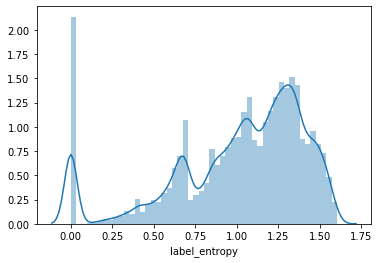

In [33]:
# category_entropy = 
nb_entropy = (results_with_gorc
                  .groupby(["nb_id","readable_label"])["n_lines"]
                  .sum()
                  .groupby("nb_id")
                  .apply(scipy.stats.entropy)
                  .rename("label_entropy"))

sns.distplot(nb_entropy)

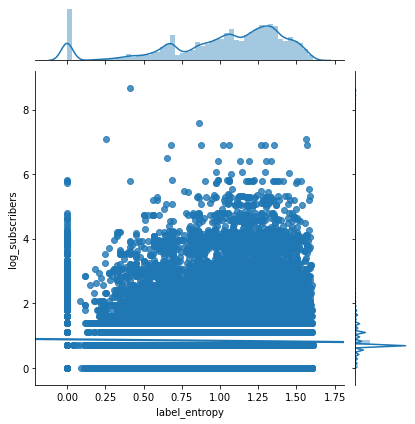

In [34]:
entropy_and_stars = (results_with_gorc[["nb_id","is_academic","stargazers_count","subscribers_count"]]
                     .merge(nb_entropy.reset_index())
                     .drop_duplicates())
entropy_and_stars["log_stars"] = np.log(entropy_and_stars["stargazers_count"] + 1)
entropy_and_stars["log_subscribers"] = np.log(entropy_and_stars["subscribers_count"] + 1) 
sns.jointplot(data = entropy_and_stars,x ="label_entropy", y = "log_subscribers", kind = "reg")


In [35]:
scipy.stats.pearsonr(entropy_and_stars["log_subscribers"],entropy_and_stars["label_entropy"])

(-0.02917035281227622, 1.1623709178449252e-23)

In [36]:
scipy.stats.spearmanr(entropy_and_stars["subscribers_count"],entropy_and_stars["label_entropy"])

SpearmanrResult(correlation=-0.021296772815394514, pvalue=2.4860470739169586e-13)

Weak, but significant, non-linear relationship in the direction we wouldn't ordinarily expect to see. Worth noting we don't see a similar relationship with stargazers

This is probably caused by having an incomplete record of notebooks. Fewer cells per notebook = artificially low entropy

In [37]:
scipy.stats.pearsonr(entropy_and_stars["stargazers_count"],entropy_and_stars["label_entropy"])

(-0.0026238957273967706, 0.36720195852878484)

In [38]:
from collections import defaultdict

def frequent_rec(patt, mdb):
    results.append((len(mdb), patt))

    occurs = defaultdict(list)
    for (i, startpos) in mdb:
        seq = db[i]
        for j in range(startpos + 1, len(seq)):
            l = occurs[seq[j]]
            if len(l) == 0 or l[-1][0] != i:
                l.append((i, j))

    for (c, newmdb) in occurs.items():
        if len(newmdb) >= minsup:
            frequent_rec(patt + [c], newmdb)


In [39]:
entropy_and_stars.describe()

,nb_id,stargazers_count,subscribers_count,label_entropy,log_stars,log_subscribers
count,118104.000000,118104.000000,118104.000000,118104.000000,118104.000000,118104.000000
mean,505979.637108,8.914050,2.672492,1.017311,0.343127,0.831948
std,287111.210331,248.548931,22.866941,0.404421,0.869608,0.643321
min,585.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,259016.500000,0.000000,1.000000,0.814595,0.000000,0.693147
50%,509693.500000,0.000000,1.000000,1.103433,0.000000,0.693147
75%,752418.000000,0.000000,1.000000,1.318593,0.000000,0.693147
max,999981.000000,64538.000000,5732.000000,1.606137,11.075025,8.653994


In [40]:
results_with_gorc.groupby(["nb_id"]).size().describe()

count    118104.000000
mean         17.007959
std          19.828250
min           1.000000
25%           5.000000
50%          11.000000
75%          21.000000
max         413.000000
dtype: float64

In [41]:
results_with_gorc.groupby(["nb_id"])["n_lines"].sum().describe()

count    118104.000000
mean         91.241965
std          85.669508
min           2.000000
25%          40.000000
50%          69.000000
75%         116.000000
max        4032.000000
Name: n_lines, dtype: float64

In [42]:
(results_with_gorc
                  .groupby(["nb_id","readable_label"])["n_lines"]
                  .sum().describe())

count    427373.000000
mean         25.214604
std          29.538667
min           2.000000
25%           8.000000
50%          17.000000
75%          32.000000
max        2142.000000
Name: n_lines, dtype: float64

Why so many imports in academic notebooks?

# Gorc Metadata
Let's see what's in the GORC metadata

What's up with the onces without `mag_fos`? Or no `inbound_citations?`

Had to skips some lines because the file wouldn't parse otherwise

In [43]:
#pd.eval
gorc_metadata = pd.read_csv("/projects/bdata/gorc/gorc_metadata.tsv", sep = "\t", error_bad_lines= False,
                           usecols = ["pid","mag_fos","inbound_citations","year"])

/homes/gws/mikeam/anaconda3/envs/analysis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Number of citations 

In [44]:
def n_inbound_citations(x):
    try:
        citations =  ast.literal_eval(x)
        return len(citations)
    except ValueError:
        return np.nan
    
gorc_metadata["n_inbound_citations"] = gorc_metadata["inbound_citations"].map(n_inbound_citations)

In [45]:
def n_inbound_citations(x):
    try:
        citations =  ast.literal_eval(x)
        return len(citations)
    except ValueError:
        return np.nan
    

def get_domains(x):
    try:
        parsed_list = ast.literal_eval(x)
        if len(parsed_list) < 1:
            return np.nan
        return parsed_list
    except (ValueError,TypeError):
        return np.nan

gorc_metadata["n_inbound_citations"] = gorc_metadata["inbound_citations"].map(n_inbound_citations)
gorc_metadata["mag_fos"] = gorc_metadata["mag_fos"].map(get_domains)

In [46]:
gorc_metadata_with_notebooks = gorc_metadata.merge(results_with_gorc, left_on = "pid", right_on = "paper_id",
                                                   how = "left")

gorc_metadata_with_notebooks["has_notebook"] = ~gorc_metadata_with_notebooks["nb_id"].isnull()
gorc_domains = gorc_metadata_with_notebooks.dropna(subset = ["mag_fos"]).explode("mag_fos")
gorc_domains = gorc_domains.drop_duplicates(["pid","has_notebook","mag_fos"])

Note that some papers are listed in multiple domains:

In [47]:
gorc_domains.drop_duplicates(["pid","has_notebook","mag_fos"]).groupby(["pid"]).size().describe()

count    1.462432e+07
mean     1.014064e+00
std      1.713778e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.870000e+02
dtype: float64

We want to limit ourselves to the top-n domains:

In [48]:
n_domains = 10
gorc_domains_per_paper = gorc_domains.drop_duplicates(["pid","mag_fos"])
top_n_domains = gorc_domains_per_paper.groupby("mag_fos").size().sort_values(ascending = False)[:n_domains].index

papers_in_top_n_domains = gorc_domains_per_paper[gorc_domains_per_paper["mag_fos"].isin(top_n_domains)]

In [49]:
#Add an intercept
one_hot_domains = pd.get_dummies(papers_in_top_n_domains["mag_fos"])
to_ols = pd.concat([papers_in_top_n_domains[["n_inbound_citations","has_notebook","year_x"]],one_hot_domains],
                  axis = 1).dropna()
to_ols["has_notebook"] = to_ols["has_notebook"].astype(int)
to_ols["year_x"] = to_ols["year_x"].astype(int)

def get_ols_fit(y,X):
    model = sm.OLS(y, X)
    results = model.fit()
    print(results.summary())
    return results

get_ols_fit(to_ols["n_inbound_citations"],to_ols.iloc[:,1:])

                             OLS Regression Results                            
Dep. Variable:     n_inbound_citations   R-squared:                       0.008
Model:                             OLS   Adj. R-squared:                  0.008
Method:                  Least Squares   F-statistic:                 1.067e+04
Date:                 Wed, 22 Jan 2020   Prob (F-statistic):               0.00
Time:                         14:43:10   Log-Likelihood:            -7.0702e+07
No. Observations:             13708391   AIC:                         1.414e+08
Df Residuals:                 13708379   BIC:                         1.414e+08
Df Model:                           11                                         
Covariance Type:             nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
has_notebook          2.5054

In [50]:
gorc_metadata_with_notebooks["has_notebook"].sum()

17495

# Mining Sequences

In [51]:
import skopus

In [52]:
readable_sequences = results.sort_values(["nb_id","code_line_no"]).groupby(["nb_id"])["readable_label"].apply(list)
skpous_command = skopus.skopus(readable_sequences.to_list(), k =10, l = 5)
#Can't get subprocess module to run, so I have to use this instead:

In [53]:
! $skpous_command

bootstrap 3
Finished bootstrap depth 2
finished bootstrap 3
Bootstrap done
Content topK Total K Itemset Number: 	10
<IMPORT, EXPLORE>		Support=60906	Interestingness=12471.5
<IMPORT, MODEL>		Support=61302	Interestingness=12419.0
<IMPORT, EVALUATE>		Support=40198	Interestingness=10968.5
<IMPORT, MODEL, MODEL>		Support=48637	Interestingness=9381.5
<IMPORT, WRANGLE>		Support=59901	Interestingness=9336.0
<IMPORT, EXPLORE, EXPLORE>		Support=48249	Interestingness=9278.0
<IMPORT, EVALUATE, EVALUATE>		Support=24736	Interestingness=6569.0
<IMPORT, WRANGLE, WRANGLE>		Support=44587	Interestingness=6442.5
<IMPORT, MODEL, EXPLORE>		Support=46638	Interestingness=6271.0
<IMPORT, WRANGLE, EXPLORE>		Support=46453	Interestingness=5520.0


Execution time= 1292262 ms
OK


In [54]:
skpous_command

'java -Xmx1G -classpath /homes/gws/mikeam/RobustDS/skopus skopus.InterestingnessMeasureMain /homes/gws/mikeam/RobustDS/skopus/tmp_x_in /homes/gws/mikeam/RobustDS/skopus/tmp_label_out -i2 -m1 -k10 -l5'

## Data / Features that we need:
* Notebooks/Repo relationship
* Total length of each notebook?
* How much should we worry about partial notebooks?
    * Probably a lot if we want to extend our unit of analysis outside of individual cells

In [55]:
!test -f /projects/bdata/jupyter/target/nb_589.py 

In [56]:
print("hey")

hey


In [57]:
gorc_metadata.groupby("has_notebook")["n_inbound_citations"].count()

KeyError: 'has_notebook'

In [ ]:
print("hey")